# Reinforcement Learning Project: Maze

We create a 6 by 6 maze for an agent to navigate out.

This tutorial is editted from this post.

https://towardsdatascience.com/hands-on-introduction-to-reinforcement-learning-in-python-da07f7aaca88

# Import Library and Define Possible Actions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# Possible Action that can be done by the agent
ACTIONS = {'U': (-1, 0), 'D': (1, 0), 'L': (0, -1), 'R': (0, 1)}

# Define Maze Class

## Initialize
1. Maze
2. Track movement history
3. Robot position, allowed states, etc

## Methods
1. is_allowed_move: Check if the agent is allowed to move in this direction
2. construct_allowed_states: Check where is the agent allowed to move
3. update_maze: Update the position of the agent
4. is_game_over: Check if the game is ended
5. give_reward: Compute the reward after each actions
6. get_state_and_reward: Get the position and reward after each action

In [2]:
class Maze(object):
    
    def __init__(self):

        #################################################################
        # Defining the Maze
        #################################################################
        self.maze = np.zeros((6, 6))
        self.maze[0, 0] = 2
        self.maze[5, :5] = 1
        self.maze[:4, 5] = 1
        self.maze[2, 2:] = 1
        self.maze[3, 2] = 1
        
        #################################################################
        # Keep track of movement history
        #################################################################
        self.movement_history = []
        
        #################################################################
        # Others
        #################################################################
        self.robot_position = (0, 0)     # current robot position
        self.steps = 0                   # contains num steps robot took
        self.allowed_states = None       # for now, this is none
        self.construct_allowed_states()  # not implemented yet
        
        
    #################################################################
    # Check if the agent is allowed to move in a specific direction
    #################################################################
    def is_allowed_move(self, state, action):
        y, x = state
        y += ACTIONS[action][0]
        x += ACTIONS[action][1]
        
        # Moving off the board
        if ((y < 0) or 
            (x < 0) or 
            (y > 5) or 
            (x > 5)):
             return False
        
        # Moving into start position or empty space
        if self.maze[y, x] == 1:
            return False
        else:
            return True
        
    #################################################################
    # Find all the directions that the agent is allowed to move
    #################################################################
    def construct_allowed_states(self):
        allowed_states = {}
        for y, row in enumerate(self.maze):
            for x, col in enumerate(row):
                # Iterate through all valid spaces
                if self.maze[(y,x)] != 1:
                    allowed_states[(y,x)] = []
                    for action in ACTIONS:
                        if self.is_allowed_move((y, x), action):
                            allowed_states[(y,x)].append(action)
                            
        self.allowed_states = allowed_states
        
        
    #################################################################
    # Update the position of the agent within the maze
    #################################################################
    def update_maze(self, action):
        
        y, x = self.robot_position
        
        # Set the current position to empty
        self.maze[y, x] = 0
        
        # Find new position
        y += ACTIONS[action][0]
        x += ACTIONS[action][1]
        self.robot_position = (y, x)
        self.maze[y, x] = 2
        self.steps += 1
        
        # Keep track of the path the agent moved
        self.movement_history.append(action)

        
    #################################################################
    # If the agent reach the end, ends the game
    #################################################################
    def is_game_over(self):
        if self.robot_position == (5, 5):
            
            print('Actions required:', self.steps)
            #print(self.maze)
            print('Actions:', self.movement_history)
            
            return True
        return False
    
    #################################################################
    # At every step, give reward
    #################################################################
    def give_reward(self):
        if self.robot_position == (5, 5):
            return 0
        else:
            return -1
        
    #################################################################
    # Update agent position and reward
    #################################################################
    def get_state_and_reward(self):
        return self.robot_position, self.give_reward()

# Define Agent Class

## Initialize
1. State history
2. Alpha - Learning rate
3. Random factor - Exploration rate
4. Reward table G

## Methods
1. init_reward: Generate a random reward table
2. choose_action: From the list of actions allowed, select one action to perform based on G and random factor
3. update_state_history: Update the state and reward
4. learn: Update the reward table G

In [3]:
class Agent(object):
    
    def __init__(self, states, alpha=0.15, random_factor=0.2):
        
        #################################################################
        # Define intial variables
        #################################################################
        self.state_history = [((0, 0), 0)] # State (x,y), reward
        self.alpha = alpha                 # Learning rate
        self.random_factor = random_factor # Exploration rate
        
        #################################################################
        # Initialize reward table
        #################################################################
        self.G = {}
        self.init_reward(states)
        
    #################################################################
    # Initalize reward table with values 0.1-1.0
    #################################################################
    def init_reward(self, states):
        for i, row in enumerate(states):
            for j, col in enumerate(row):
                self.G[(j,i)] = np.random.uniform(high=1.0, low=0.1)
                
    #################################################################
    # Choose direction to move
    #################################################################
    def choose_action(self, state, allowed_moves):
        next_move = None
        
        # Generate a random number 0 to 1
        n = np.random.random()
        
        # If n < self.random_factor -> Explore -> Go any random move
        if n < self.random_factor:
            next_move = np.random.choice(allowed_moves)
            
        # Eploit -> Go the path with highest expected reward
        else:
            # some really small random number
            maxG = -10e15
            
            # From all the allowed move
            # Find the one with the highest reward and go there
            for action in allowed_moves:
                new_state = tuple([sum(x) for x in zip(state, ACTIONS[action])])
                if self.G[new_state] >= maxG:
                    next_move = action
                    maxG = self.G[new_state]
        return next_move
    
    #################################################################
    # Update the state history
    #################################################################
    def update_state_history(self, state, reward):
        self.state_history.append((state, reward))

        
    #################################################################
    # Update the reward table
    #################################################################
    def learn(self):
        target = 0

        for prev, reward in reversed(self.state_history):
            self.G[prev] = self.G[prev] + self.alpha * (target - self.G[prev])
            target += reward

        self.state_history = []
        
        # Reduce exploration rate over time
        self.random_factor -= 10e-5 # decrease random factor each episode of play
        print(self.random_factor)

# Check the inital reward table of the agent

In [4]:
maze = Maze()
robot = Agent(maze.maze, 
              alpha=0.1,         # Learning rate 
              random_factor=0.25 # Exploration rate
             )

robot.G

{(0, 0): 0.7483563694909954,
 (1, 0): 0.7998069351477858,
 (2, 0): 0.21525276241915606,
 (3, 0): 0.8643662835853282,
 (4, 0): 0.6013367890858482,
 (5, 0): 0.3716093667131928,
 (0, 1): 0.3483380886440147,
 (1, 1): 0.892905372561205,
 (2, 1): 0.3958878202062953,
 (3, 1): 0.4528746345194701,
 (4, 1): 0.8273407301151993,
 (5, 1): 0.9490120999092766,
 (0, 2): 0.7767580044500346,
 (1, 2): 0.7411173084124346,
 (2, 2): 0.2903938951046182,
 (3, 2): 0.1640754867996497,
 (4, 2): 0.2792930987353515,
 (5, 2): 0.11697322815693643,
 (0, 3): 0.4913411505112999,
 (1, 3): 0.6708267703982762,
 (2, 3): 0.7014218176238648,
 (3, 3): 0.8158738216715814,
 (4, 3): 0.9507335922284912,
 (5, 3): 0.5506398656745509,
 (0, 4): 0.7496073219084737,
 (1, 4): 0.40166481684102673,
 (2, 4): 0.24049532087837794,
 (3, 4): 0.8194623556244437,
 (4, 4): 0.2254716465753961,
 (5, 4): 0.7296447089040519,
 (0, 5): 0.4439953377694499,
 (1, 5): 0.602670630515633,
 (2, 5): 0.780358368142228,
 (3, 5): 0.9998846725144537,
 (4, 5): 0.12

# Run main and let the agent learn from the environment

In [5]:
if __name__ == '__main__':
    
    # Create Maze and Agent
    maze = Maze()
    robot = Agent(maze.maze, 
                  alpha=0.1,         # Learning rate 
                  random_factor=0.25 # Exploration rate
                 )
    
    moveHistory = []

    # Loop for 3000 times
    for i in range(3000):
        print('\nLoop:', i+1)

        # Reinitialize the maze
        maze = Maze()
        
        # Conduct an action per turn
        while not maze.is_game_over():
            # Get the current state
            state, _ = maze.get_state_and_reward()
            
            # choose an action (explore or exploit)
            action = robot.choose_action(state, maze.allowed_states[state])
            
            # Update the maze according to the action
            maze.update_maze(action)
            
            # Get the new state and reward
            state, reward = maze.get_state_and_reward()
            
            # Update the robot memory with state and reward
            robot.update_state_history(state, reward)
            
            if maze.steps > 1000:
                # End the robot if it takes too long to find the goal
                # Set position to (5,5) to end the game
                maze.robot_position = (5,5)
        
        # Robot should learn after every episode
        robot.learn()
        
        # Get a history of number of steps taken to plot later
        moveHistory.append(maze.steps)


Loop: 1
Actions required: 1001
Actions: ['D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'R', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'R', 'L', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'U', 'L', 'D', 'U', 'D', 'U', 'R', 'L', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'R', 'L', 'R', 'L', 'D', 'U', 'R', 'L', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'R', 'L', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'R', 'R', 'L', 'R', 'U', 'D', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'R', 'L', 'L', 'R', 'L', 'R', 'L', 'R', 'R', 'L', 'R', 'L', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'L', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'D', 'U', 'R', 'R', 'L', 'R', 'R', 'L', 'L', 'R', 'L', 'R', 'L', 'R', 'L', 'R', 'U', 'D', 'L', 'L', 'U', 'D', 'D', 'U', 'U'

Actions required: 10
Actions: ['D', 'R', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'D']
0.22670000000000257

Loop: 234
Actions required: 12
Actions: ['D', 'R', 'D', 'D', 'D', 'R', 'R', 'R', 'U', 'D', 'R', 'D']
0.22660000000000258

Loop: 235
Actions required: 10
Actions: ['D', 'R', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'D']
0.2265000000000026

Loop: 236
Actions required: 14
Actions: ['D', 'U', 'R', 'D', 'D', 'D', 'D', 'U', 'D', 'R', 'R', 'R', 'R', 'D']
0.2264000000000026

Loop: 237
Actions required: 14
Actions: ['D', 'R', 'D', 'D', 'D', 'R', 'R', 'R', 'L', 'R', 'R', 'L', 'R', 'D']
0.2263000000000026

Loop: 238
Actions required: 14
Actions: ['D', 'D', 'R', 'D', 'D', 'R', 'R', 'R', 'R', 'L', 'U', 'D', 'R', 'D']
0.22620000000000262

Loop: 239
Actions required: 22
Actions: ['D', 'R', 'L', 'U', 'D', 'R', 'R', 'L', 'R', 'L', 'D', 'D', 'D', 'R', 'R', 'R', 'L', 'U', 'D', 'R', 'R', 'D']
0.22610000000000263

Loop: 240
Actions required: 22
Actions: ['D', 'U', 'D', 'U', 'D', 'R', 'D', 'D', 'D', 'L', 'R', 'R'

Actions required: 10
Actions: ['R', 'D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'D']
0.19760000000000577

Loop: 525
Actions required: 12
Actions: ['R', 'D', 'D', 'D', 'D', 'R', 'R', 'R', 'U', 'D', 'R', 'D']
0.19750000000000578

Loop: 526
Actions required: 12
Actions: ['R', 'D', 'D', 'D', 'D', 'L', 'R', 'R', 'R', 'R', 'R', 'D']
0.1974000000000058

Loop: 527
Actions required: 10
Actions: ['R', 'D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'D']
0.1973000000000058

Loop: 528
Actions required: 14
Actions: ['R', 'D', 'D', 'D', 'D', 'R', 'L', 'R', 'R', 'U', 'D', 'R', 'R', 'D']
0.19720000000000582

Loop: 529
Actions required: 14
Actions: ['R', 'D', 'L', 'R', 'D', 'U', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'D']
0.19710000000000583

Loop: 530
Actions required: 10
Actions: ['R', 'D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'D']
0.19700000000000584

Loop: 531
Actions required: 10
Actions: ['D', 'R', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'D']
0.19690000000000585

Loop: 532
Actions required: 16
Actions: ['R', 'R', 'L', 

Actions required: 10
Actions: ['D', 'D', 'R', 'D', 'D', 'R', 'R', 'R', 'R', 'D']
0.16590000000000926

Loop: 842
Actions required: 10
Actions: ['D', 'D', 'R', 'D', 'D', 'R', 'R', 'R', 'R', 'D']
0.16580000000000927

Loop: 843
Actions required: 14
Actions: ['D', 'U', 'D', 'D', 'R', 'D', 'L', 'R', 'D', 'R', 'R', 'R', 'R', 'D']
0.16570000000000928

Loop: 844
Actions required: 10
Actions: ['D', 'D', 'R', 'D', 'D', 'R', 'R', 'R', 'R', 'D']
0.1656000000000093

Loop: 845
Actions required: 12
Actions: ['D', 'D', 'R', 'D', 'D', 'R', 'R', 'R', 'R', 'L', 'R', 'D']
0.1655000000000093

Loop: 846
Actions required: 12
Actions: ['D', 'D', 'R', 'D', 'D', 'R', 'L', 'R', 'R', 'R', 'R', 'D']
0.16540000000000932

Loop: 847
Actions required: 10
Actions: ['D', 'D', 'R', 'D', 'D', 'R', 'R', 'R', 'R', 'D']
0.16530000000000933

Loop: 848
Actions required: 14
Actions: ['D', 'D', 'R', 'D', 'U', 'D', 'L', 'R', 'D', 'R', 'R', 'R', 'R', 'D']
0.16520000000000934

Loop: 849
Actions required: 12
Actions: ['D', 'D', 'D', 

Actions required: 10
Actions: ['D', 'R', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'D']
0.13310000000001287

Loop: 1170
Actions required: 10
Actions: ['D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'R', 'D']
0.13300000000001289

Loop: 1171
Actions required: 10
Actions: ['D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'R', 'D']
0.1329000000000129

Loop: 1172
Actions required: 10
Actions: ['D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'R', 'D']
0.1328000000000129

Loop: 1173
Actions required: 10
Actions: ['D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'R', 'D']
0.13270000000001292

Loop: 1174
Actions required: 12
Actions: ['D', 'D', 'D', 'D', 'R', 'L', 'R', 'R', 'R', 'R', 'R', 'D']
0.13260000000001293

Loop: 1175
Actions required: 14
Actions: ['D', 'U', 'D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'R', 'L', 'R', 'D']
0.13250000000001294

Loop: 1176
Actions required: 12
Actions: ['D', 'D', 'D', 'D', 'U', 'D', 'R', 'R', 'R', 'R', 'R', 'D']
0.13240000000001295

Loop: 1177
Actions required: 10
Actions: ['D', 'D', 'D', 'D', 'R', 'R

Actions required: 10
Actions: ['D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'R', 'D']
0.098400000000013

Loop: 1517
Actions required: 10
Actions: ['D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'R', 'D']
0.098300000000013

Loop: 1518
Actions required: 10
Actions: ['D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'R', 'D']
0.098200000000013

Loop: 1519
Actions required: 10
Actions: ['D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'R', 'D']
0.098100000000013

Loop: 1520
Actions required: 10
Actions: ['D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'R', 'D']
0.098000000000013

Loop: 1521
Actions required: 10
Actions: ['D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'R', 'D']
0.09790000000001299

Loop: 1522
Actions required: 10
Actions: ['D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'R', 'D']
0.09780000000001299

Loop: 1523
Actions required: 14
Actions: ['D', 'U', 'D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'L', 'R', 'R', 'D']
0.09770000000001298

Loop: 1524
Actions required: 12
Actions: ['D', 'D', 'D', 'D', 'R', 'R', 'R', 'L', 'R', 'R', 'R', 

Loop: 1862
Actions required: 12
Actions: ['R', 'R', 'L', 'D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'D']
0.06380000000001201

Loop: 1863
Actions required: 10
Actions: ['R', 'D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'D']
0.06370000000001201

Loop: 1864
Actions required: 10
Actions: ['R', 'D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'D']
0.06360000000001201

Loop: 1865
Actions required: 10
Actions: ['R', 'D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'D']
0.063500000000012

Loop: 1866
Actions required: 10
Actions: ['R', 'D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'D']
0.063400000000012

Loop: 1867
Actions required: 10
Actions: ['R', 'D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'D']
0.063300000000012

Loop: 1868
Actions required: 10
Actions: ['R', 'D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'D']
0.063200000000012

Loop: 1869
Actions required: 12
Actions: ['R', 'D', 'D', 'D', 'D', 'R', 'R', 'R', 'L', 'R', 'R', 'D']
0.063100000000012

Loop: 1870
Actions required: 12
Actions: ['R', 'L', 'R', 'D', 'D', 'D', 'D', 'R', 'R',

0.029300000000011095

Loop: 2208
Actions required: 10
Actions: ['R', 'D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'D']
0.029200000000011096

Loop: 2209
Actions required: 10
Actions: ['R', 'D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'D']
0.029100000000011096

Loop: 2210
Actions required: 10
Actions: ['R', 'D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'D']
0.029000000000011097

Loop: 2211
Actions required: 10
Actions: ['R', 'D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'D']
0.028900000000011097

Loop: 2212
Actions required: 10
Actions: ['R', 'D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'D']
0.028800000000011098

Loop: 2213
Actions required: 12
Actions: ['R', 'D', 'D', 'D', 'D', 'R', 'R', 'U', 'D', 'R', 'R', 'D']
0.0287000000000111

Loop: 2214
Actions required: 10
Actions: ['R', 'D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'D']
0.0286000000000111

Loop: 2215
Actions required: 10
Actions: ['R', 'D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'D']
0.0285000000000111

Loop: 2216
Actions required: 10
Actions: ['R', 'D', 'D', 'D', 


Loop: 2543
Actions required: 10
Actions: ['R', 'D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'D']
-0.0042999999999887815

Loop: 2544
Actions required: 10
Actions: ['R', 'D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'D']
-0.004399999999988782

Loop: 2545
Actions required: 10
Actions: ['R', 'D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'D']
-0.004499999999988782

Loop: 2546
Actions required: 10
Actions: ['R', 'D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'D']
-0.004599999999988782

Loop: 2547
Actions required: 10
Actions: ['R', 'D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'D']
-0.004699999999988783

Loop: 2548
Actions required: 10
Actions: ['R', 'D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'D']
-0.004799999999988783

Loop: 2549
Actions required: 10
Actions: ['R', 'D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'D']
-0.004899999999988783

Loop: 2550
Actions required: 10
Actions: ['R', 'D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'D']
-0.004999999999988783

Loop: 2551
Actions required: 10
Actions: ['R', 'D', 'D', 'D', 'D', 'R', 'R', '

Actions required: 10
Actions: ['R', 'D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'D']
-0.03959999999998889

Loop: 2897
Actions required: 10
Actions: ['R', 'D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'D']
-0.03969999999998889

Loop: 2898
Actions required: 10
Actions: ['R', 'D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'D']
-0.03979999999998889

Loop: 2899
Actions required: 10
Actions: ['R', 'D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'D']
-0.039899999999988896

Loop: 2900
Actions required: 10
Actions: ['R', 'D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'D']
-0.0399999999999889

Loop: 2901
Actions required: 10
Actions: ['R', 'D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'D']
-0.0400999999999889

Loop: 2902
Actions required: 10
Actions: ['R', 'D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'D']
-0.040199999999988904

Loop: 2903
Actions required: 10
Actions: ['R', 'D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'D']
-0.04029999999998891

Loop: 2904
Actions required: 10
Actions: ['R', 'D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'D']
-0.0403

# Plot Steps Rquired before game over or terminated

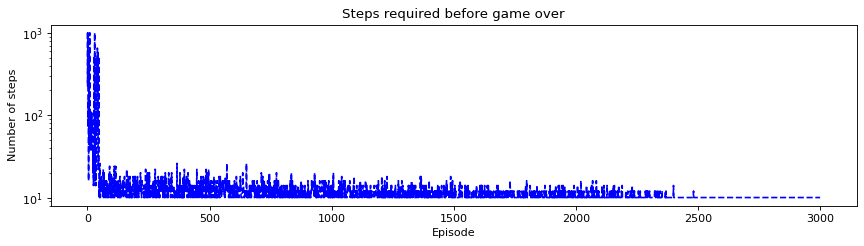

In [11]:
plt.figure(figsize=(13, 3), dpi=80)
plt.semilogy(moveHistory, "b--")
plt.title('Steps required before game over')
plt.ylabel('Number of steps')
plt.xlabel('Episode')
plt.show()

# Check the updated reward table of the agent

In [7]:
robot.G

{(0, 0): -9.67516111108545,
 (1, 0): -9.393170747299356,
 (2, 0): -7.851650076269409,
 (3, 0): -6.7659446327570665,
 (4, 0): -5.5532420533833085,
 (5, 0): 0.9297881378829942,
 (0, 1): -8.000000000000007,
 (1, 1): -7.0000000000000036,
 (2, 1): -6.0000000000000036,
 (3, 1): -5.0000000000000036,
 (4, 1): -4.0000000000000036,
 (5, 1): 0.2958155064579604,
 (0, 2): -26.73369451008818,
 (1, 2): -13.665983226837318,
 (2, 2): 0.935505906643059,
 (3, 2): 0.9750711665487521,
 (4, 2): -3.0000000000000018,
 (5, 2): 0.855050499104717,
 (0, 3): -332.7493324615252,
 (1, 3): -302.28526061934247,
 (2, 3): 0.6571121871472011,
 (3, 3): -3.3808620868957373,
 (4, 3): -2.0000000000000018,
 (5, 3): 0.5955084213208207,
 (0, 4): -375.0993149602924,
 (1, 4): -435.4264014271875,
 (2, 4): 0.7483059000619742,
 (3, 4): -2.276816109145439,
 (4, 4): -1.0000000000000009,
 (5, 4): 0.7888517998561424,
 (0, 5): 0.8859244659781429,
 (1, 5): 0.1906905008264676,
 (2, 5): 0.4911793805662682,
 (3, 5): 0.9731588957105055,
 (4, 

# We visualize the reward table across the environment (x,y)
We set the "walls" to be -10000

Note:
- Only the goal is 0
- The other path will always be a negative value

In [8]:
matrix_G = np.zeros((6,6))

for i in robot.G:
    x, y = i
    reward = robot.G[i]
    matrix_G[x,y] = reward

matrix_G = np.round(matrix_G,3)
matrix_G[matrix_G>0] = -10000

np.set_printoptions(suppress=True)
print(matrix_G)

[[    -9.675     -8.       -26.734   -332.749   -375.099 -10000.   ]
 [    -9.393     -7.       -13.666   -302.285   -435.426 -10000.   ]
 [    -7.852     -6.    -10000.    -10000.    -10000.    -10000.   ]
 [    -6.766     -5.    -10000.        -3.381     -2.277 -10000.   ]
 [    -5.553     -4.        -3.        -2.        -1.        -0.   ]
 [-10000.    -10000.    -10000.    -10000.    -10000.         0.   ]]


# Print the best action set

In [9]:
maze.movement_history

['R', 'D', 'D', 'D', 'D', 'R', 'R', 'R', 'R', 'D']

# Plot the reward table as a color map

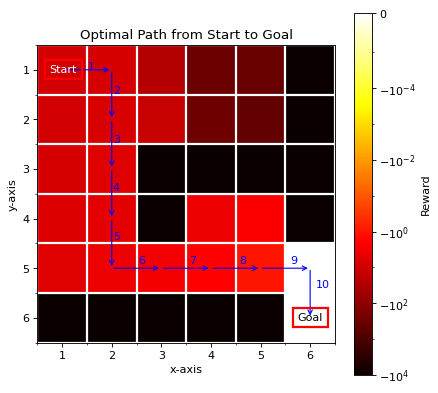

In [10]:
#################################################################
# Compute parameters to plot log scale color bar
#################################################################
logthresh = 5
vmin = np.min(matrix_G)
vmax = np.max([np.max(matrix_G), 1])
maxlog=int(np.ceil(np.log10(vmax) ))
minlog=int(np.ceil(np.log10(-vmin) ))

#################################################################
# Plot color map
#################################################################
plt.figure(figsize=(6, 6), dpi=80)
plt.imshow(matrix_G, 
           cmap='hot', 
           #interpolation='nearest',
           norm=matplotlib.colors.SymLogNorm(10**-logthresh)
          )

#################################################################
# Plot action path from start to goal
#################################################################
action_list = maze.movement_history

start_x = 0
start_y = 0
for i, action in enumerate(action_list):
    end_x = start_x + ACTIONS[action][0]
    end_y = start_y + ACTIONS[action][1]
    
    plt.annotate('', 
                 xytext=(end_y, end_x),
                 xy=(start_y, start_x), 
                 arrowprops=dict(arrowstyle="<-", color='blue'))
    
    x_mid = (start_x+end_x)/2
    y_mid = (start_y+end_y)/2
    
    plt.annotate(i+1, 
                 xytext=(y_mid, x_mid),
                 xy=(y_mid, x_mid), 
                 color='blue',
                 textcoords='offset points')
    
    start_x = end_x
    start_y = end_y

plt.text(4.75, 5.05, 'Goal', 
         bbox=dict(fill=False, edgecolor='red', linewidth=2))
plt.text(-0.25, 0.05, 'Start', color='white', 
         bbox=dict(fill=False, edgecolor='red', linewidth=2))
    
#################################################################
# Generate logarithmic ticks 
#################################################################
tick_locations=([-(10**x) for x in range(minlog,-logthresh-1,-2)]
                +[0.0]
                +[(10**x) for x in range(-logthresh,maxlog+1,2)])

#################################################################
# Generating grid for clearer illustration
#################################################################
ax = plt.gca();

# Major ticks
ax.set_xticks(np.arange(0, 6, 1))
ax.set_yticks(np.arange(0, 6, 1))

# Labels for major ticks
ax.set_xticklabels(np.arange(1, 7, 1))
ax.set_yticklabels(np.arange(1, 7, 1))

# Minor ticks
ax.set_xticks(np.arange(-.5, 6, 1), minor=True)
ax.set_yticks(np.arange(-.5, 6, 1), minor=True)

# Gridlines based on minor ticks
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

#################################################################
# Add description
#################################################################
plt.title('Optimal Path from Start to Goal')
plt.xlabel('x-axis')
plt.ylabel('y-axis')

cbar = plt.colorbar(ticks=tick_locations)
cbar.set_label('Reward')

plt.show()